## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation & Preprocessing

In [3]:
def crop_brain_contour(image, plot=False):

    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

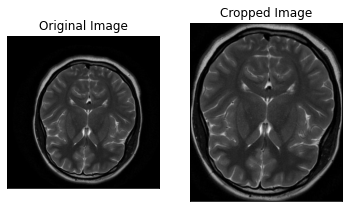

In [4]:
ex_img = cv2.imread('/content/drive/MyDrive/ResearchWork/Brain Cancer Detection/Dataset/Dataset1/BrainCancer/augmented data/no/aug_1 no._0_1187.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [5]:
def load_data(dir_list, image_size):
    
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        
        for filename in listdir(directory):
#             print(directory +"/" + filename)
#             break
            image = cv2.imread(directory + "/" +  filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_yes = '/content/drive/MyDrive/ResearchWork/Brain Cancer Detection/Dataset/Dataset1/BrainCancer/augmented data/yes' 
augmented_no = '/content/drive/MyDrive/ResearchWork/Brain Cancer Detection/Dataset/Dataset1/BrainCancer/augmented data/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

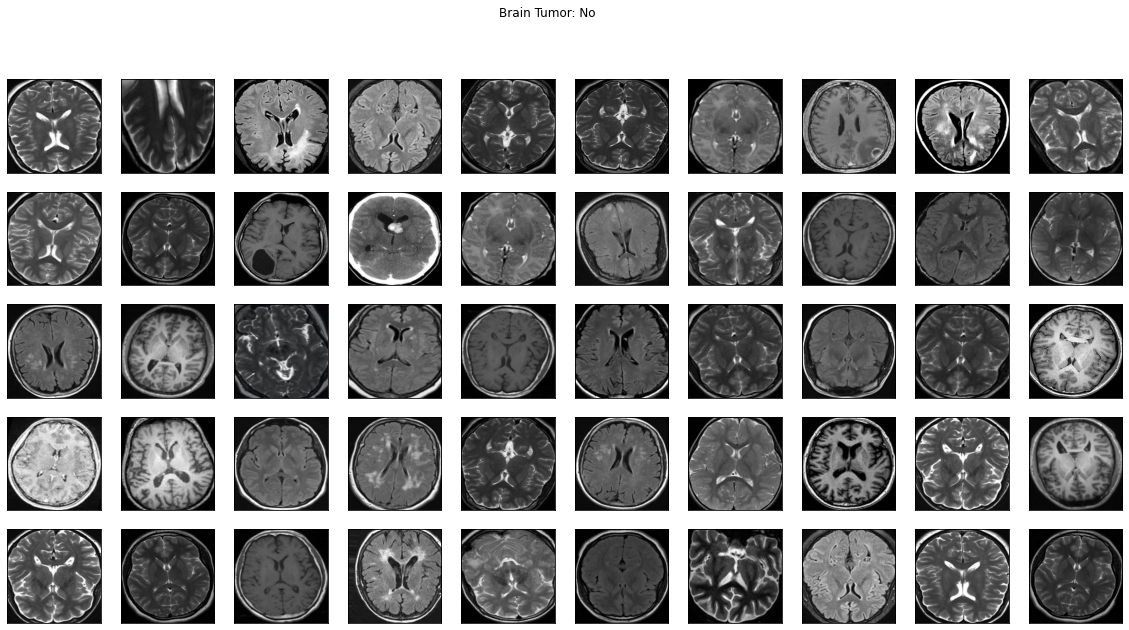

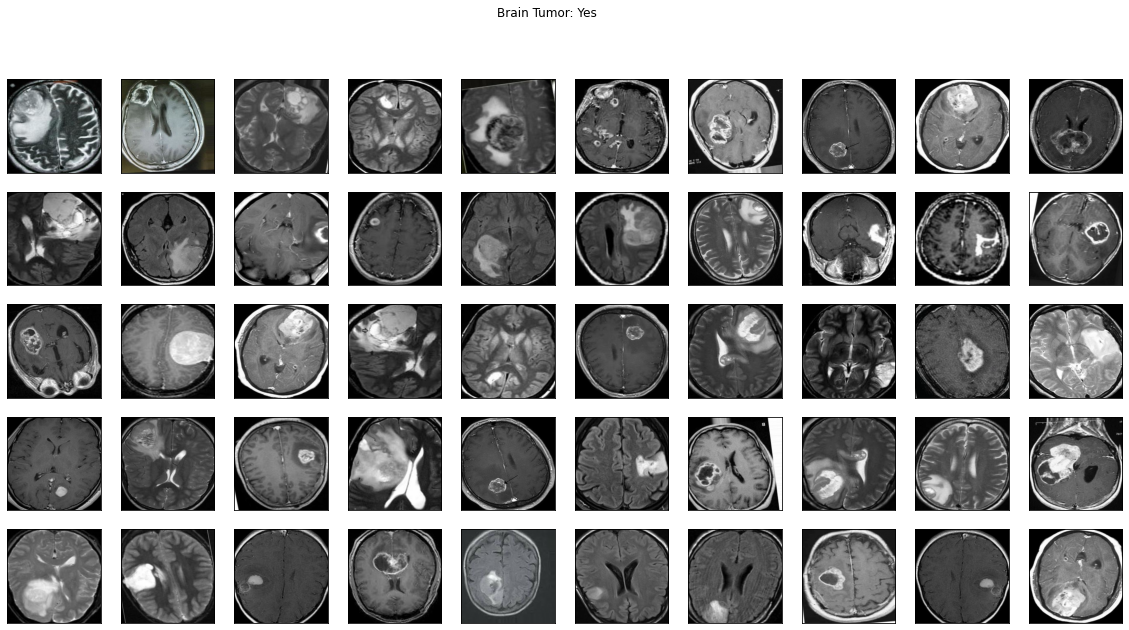

In [8]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.2):
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [12]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

<img src='convnet_architecture.jpg'>

In [15]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    X_input = Input(input_shape) 
    
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

Compile the model:

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [24]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 127s 3s/step - loss: 0.4272 - accuracy: 0.8090 - val_loss: 0.5374 - val_accuracy: 0.7581
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.76.model/assets
Epoch 2/10
46/46 [==============================] - 130s 3s/step - loss: 0.3661 - accuracy: 0.8339 - val_loss: 0.5061 - val_accuracy: 0.7581
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.76.model/assets
Epoch 3/10
46/46 [==============================] - 126s 3s/step - loss: 0.3675 - accuracy: 0.8422 - val_loss: 0.6994 - val_accuracy: 0.5903
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.59.model/assets
Epoch 4/10
46/46 [==============================] - 132s 3s/step - loss: 0.3262 - accuracy: 0.8561 - val_loss: 0.6531 - val_accuracy: 0.6387
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.64.model/assets
Epoch 5/10
46/46 [==============================] - 132s 3s/step - loss: 0.2

Let's train for a few more epochs:

In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 134s 3s/step - loss: 0.1943 - accuracy: 0.9280 - val_loss: 0.5643 - val_accuracy: 0.7613
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.76.model/assets
Epoch 2/3
46/46 [==============================] - 140s 3s/step - loss: 0.1481 - accuracy: 0.9516 - val_loss: 0.2941 - val_accuracy: 0.8806
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.88.model/assets
Epoch 3/3
46/46 [==============================] - 129s 3s/step - loss: 0.1546 - accuracy: 0.9481 - val_loss: 0.3794 - val_accuracy: 0.8355
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.84.model/assets
Elapsed time: 0:6:47.0


In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 133s 3s/step - loss: 0.1590 - accuracy: 0.9439 - val_loss: 0.4465 - val_accuracy: 0.8097
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.81.model/assets
Epoch 2/3
46/46 [==============================] - 128s 3s/step - loss: 0.1345 - accuracy: 0.9571 - val_loss: 1.1155 - val_accuracy: 0.6419
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.64.model/assets
Epoch 3/3
46/46 [==============================] - 132s 3s/step - loss: 0.1535 - accuracy: 0.9370 - val_loss: 0.2945 - val_accuracy: 0.8871
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.89.model/assets
Elapsed time: 0:7:23.1


In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 134s 3s/step - loss: 0.1455 - accuracy: 0.9460 - val_loss: 0.3180 - val_accuracy: 0.8742
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.87.model/assets
Epoch 2/3
46/46 [==============================] - 132s 3s/step - loss: 0.1078 - accuracy: 0.9633 - val_loss: 0.5544 - val_accuracy: 0.8065
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.81.model/assets
Epoch 3/3
46/46 [==============================] - 133s 3s/step - loss: 0.0905 - accuracy: 0.9751 - val_loss: 0.2848 - val_accuracy: 0.8774
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.88.model/assets
Elapsed time: 0:7:22.4


In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - 134s 3s/step - loss: 0.0996 - accuracy: 0.9785 - val_loss: 0.3344 - val_accuracy: 0.8645
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-01-0.86.model/assets
Epoch 2/5
46/46 [==============================] - 130s 3s/step - loss: 0.0818 - accuracy: 0.9792 - val_loss: 0.3054 - val_accuracy: 0.8710
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-02-0.87.model/assets
Epoch 3/5
46/46 [==============================] - 131s 3s/step - loss: 0.0729 - accuracy: 0.9869 - val_loss: 0.2509 - val_accuracy: 0.8935
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-03-0.89.model/assets
Epoch 4/5
46/46 [==============================] - 134s 3s/step - loss: 0.0771 - accuracy: 0.9806 - val_loss: 0.3765 - val_accuracy: 0.8581
INFO:tensorflow:Assets written to: models/cnn-parameters-improvement-04-0.86.model/assets
Epoch 5/5
46/46 [==============================] - 132s 3s/step - loss: 0.0590 -

In [30]:
history = model.history.history

In [31]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [40]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

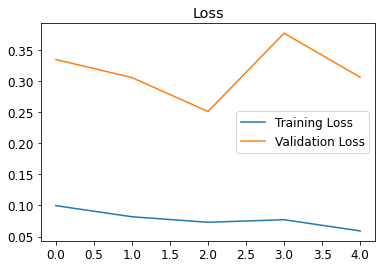

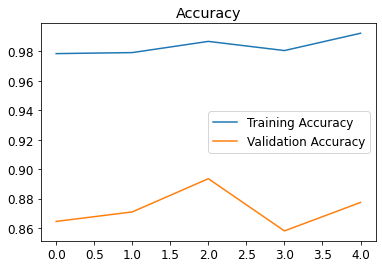

In [58]:
plot_metrics(history) 

### Results Interpretation

In [44]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [45]:
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [46]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.38754325259516%, number of pos examples: 757
Percentage of negative examples: 47.61245674740484%, number of neg examples: 688
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.54838709677419%, number of pos examples: 166
Percentage of negative examples: 46.45161290322581%, number of neg examples: 144
Testing Data:
Number of examples: 310
Percentage of positive examples: 52.25806451612903%, number of pos examples: 162
Percentage of negative examples: 47.74193548387097%, number of neg examples: 148


# Conclusion:

**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

In [48]:
y_pred = model.predict(X_test, batch_size=32)

In [51]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [53]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


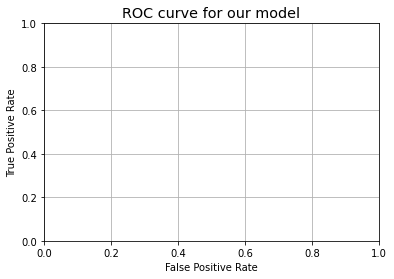

In [54]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


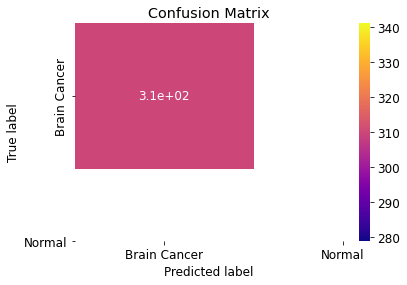

Confusion Matrix with Normalized Values


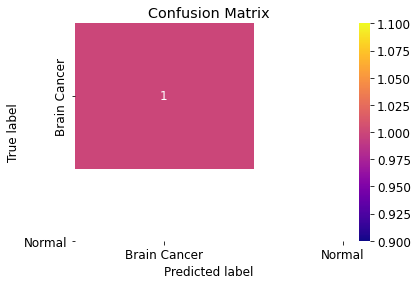

In [55]:
def plot_confusion_matrix(normalize):
  classes = ['Brain Cancer','Normal']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')